In [1]:
import json
import os
import torch.nn.functional as F
import numpy as np
import torch
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.models.segmentation.deeplabv3 import deeplabv3_resnet50, deeplabv3_resnet101
 
# Define the COCO_CLASSES and COCO_LABEL_MAP
COCO_CLASSES = ('__background__','break', 'thunderbolt', "0", "Inclusoes", "Rechupe", "Collision", "Dirty",
               "Gap", "Scratch", "Chip", "PistonMiss", "Porosity", "RCS", "damage", "s_burr", "s_scratch",
               "Defect-A", "Defect-B", "Defect-C", "Defect-D", "Fiber", "Flash Particle", "Hole", "Surface Damage",
               "Tear", "missing_hole", "mouse_bite", "open_circuit", "short", "spur", "spurious_copper",
               "defect1", "defect2", "defect3", "defect4", "defect5", "defect6", "defect7", "t_contamination",
               "t_scratch", "unfinished_surface", "defect", "impurities", "pits")
 
COCO_LABEL_MAP = {cls: idx for (idx, cls) in enumerate(COCO_CLASSES)}
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
 
 
# Define custom dataset
class VISIONDataset(Dataset):
    def __init__(self, root_dir, split="train", annotation_file='_annotations.coco.json'):
        self.root_dir = root_dir
        self.img_dir = os.path.join(self.root_dir, split)
        self.annotation_file = os.path.join(self.root_dir, split, annotation_file)
        self.annotations = self._load_annotations()
 
        # Collect all image file names
        self.img_files = sorted([f for f in os.listdir(self.img_dir)
                                 if f.endswith('.jpg') and not f.startswith('._')])
 
    def _load_annotations(self):
        with open(self.annotation_file, 'r') as f:
            return json.load(f)
 
    def _get_annotation_for_image(self, image_id):
        annotations = [ann for ann in self.annotations['annotations'] if ann['image_id'] == image_id]
        return annotations
    
    def _get_image_id_by_name(self, file_name):
        for image in self.annotations['images']:
            if image['file_name'] == file_name:
                return image['id']
        return None  # Return None if no match is found
 
    def __len__(self):
        return len(self.img_files)
 
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
       
        # Load image
        orig_image = Image.open(img_path).convert('RGB')
 
        # Find corresponding image ID by file name
        image_id = self._get_image_id_by_name(img_name)
 
        # Find corresponding annotations
        image_annotations = self._get_annotation_for_image(image_id)
 
        # Create mask
        mask = Image.new('L', orig_image.size, 0)  # Initialize with 0s for background
        draw = ImageDraw.Draw(mask)
        for annotation in image_annotations:
            class_id = annotation['category_id']
            if class_id in COCO_LABEL_MAP.values():
                segmentation = annotation['segmentation']
                if isinstance(segmentation[0], list):
                    points = [tuple(point) for segment in segmentation for point in zip(segment[::2], segment[1::2])]
                    draw.polygon(points, fill=class_id + 1)
        mask = np.array(mask)
 
        # Define the transformations including resizing to 550x550
        transform = transforms.Compose([
            transforms.Resize((550, 550)), 
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
       
        img = transform(orig_image)
 
        mask = Image.fromarray(mask).resize((550, 550), resample=Image.NEAREST)
        mask = torch.tensor(np.array(mask), dtype=torch.int64)
 
        return img, mask
 
    @staticmethod
    def visualize_mask(mask):
        fig, ax = plt.subplots(1)
        ax.imshow(mask, cmap='gray')
        ax.set_title('Segmentation Mask')
        plt.show()
 
 
def custom_collate(batch):
    images, masks = [], []
    for sample in batch:
        img, mask = sample
        if isinstance(img, torch.Tensor):
            images.append(img)
        else:
            img = transforms.ToTensor()(img)
            images.append(img)
        masks.append(mask)
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)
    return images, masks
 
 
def dice_loss(pred, target):
    smooth = 1.
    num_classes = pred.size(1)
    loss = 0.
    for c in range(num_classes):
        p = pred[:, c]
        t = target == c
        intersection = (p * t).sum()
        loss += (2. * intersection + smooth) / (p.sum() + t.sum() + smooth)
    return 1. - loss / num_classes
 
 
def jaccard_index_loss(logits, targets):
    # apply softmax to logits along the channel dimension
    probs = F.softmax(logits, dim=1)
    # get the predicted class masks from the probabilities
    pred_masks = probs.argmax(dim=1)
    # compute intersection and union between predicted and ground truth masks
    intersection = (pred_masks & targets).float().sum(dim=(1, 2))
    union = (pred_masks | targets).float().sum(dim=(1, 2))
    # compute Jaccard index and return the loss
    jaccard = intersection / union
    return (1 - jaccard).mean()


In [6]:
# Initialization
num_epochs = 5
batch_size = 8

# Initialize custom dataset and data loader
root_dir = '/Users/thanhhung/Datasets/VISION-Datasets/Cable'  # Change this to your dataset root directory
train_dataset = VISIONDataset(root_dir=root_dir, split='train')
val_dataset = VISIONDataset(root_dir=root_dir, split='val')

# Initialize dataloaders for both training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate,
                          drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate,
                        drop_last=True)

# Initialize model and optimizer
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)
# Move model and data to GPU
model = deeplabv3_resnet50(pretrained=False, num_classes=len(COCO_CLASSES))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print('Training started...')

# Initialize history to store loss values
train_loss_history = []
val_loss_history = []

# Training loop with validation phase
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0
    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        loss = torch.nn.functional.cross_entropy(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        print(
            f'Train Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Calculate average train loss for the epoch
    epoch_train_loss /= len(train_loader)
    train_loss_history.append(epoch_train_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        epoch_val_loss = 0.0
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            val_loss = torch.nn.functional.cross_entropy(outputs, masks)
            epoch_val_loss += val_loss.item()
        epoch_val_loss /= len(val_loader)
        val_loss_history.append(epoch_val_loss)
        print(f'Validation Loss after Epoch {epoch + 1}: {epoch_val_loss:.4f}')

print('Saving model...')
# Save the model checkpoint as pth file
torch.save(model.state_dict(), 'model.pth')

# Save train and validation loss history
with open('train_loss_history.txt', 'w') as f:
    for loss in train_loss_history:
        f.write(f'{loss}\n')

with open('val_loss_history.txt', 'w') as f:
    for loss in val_loss_history:
        f.write(f'{loss}\n')

Device:  cpu


/Users/thanhhung/anaconda3/envs/vqi/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/thanhhung/anaconda3/envs/vqi/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training started...
Train Epoch [1/5], Step [1/5], Loss: 3.8901
Train Epoch [1/5], Step [2/5], Loss: 3.6357
Train Epoch [1/5], Step [3/5], Loss: 3.5901
Train Epoch [1/5], Step [4/5], Loss: 3.2956
Train Epoch [1/5], Step [5/5], Loss: 2.9909
Validation Loss after Epoch 1: 13.5767
Train Epoch [2/5], Step [1/5], Loss: 2.6605
Train Epoch [2/5], Step [2/5], Loss: 2.4191
Train Epoch [2/5], Step [3/5], Loss: 2.1595
Train Epoch [2/5], Step [4/5], Loss: 1.8360
Train Epoch [2/5], Step [5/5], Loss: 1.6195
Validation Loss after Epoch 2: 26.0554
Train Epoch [3/5], Step [1/5], Loss: 1.3913
Train Epoch [3/5], Step [2/5], Loss: 1.1782
Train Epoch [3/5], Step [3/5], Loss: 1.1764
Train Epoch [3/5], Step [4/5], Loss: 0.8318
Train Epoch [3/5], Step [5/5], Loss: 0.9027
Validation Loss after Epoch 3: 204.7477
Train Epoch [4/5], Step [1/5], Loss: 0.8230
Train Epoch [4/5], Step [2/5], Loss: 0.7426
Train Epoch [4/5], Step [3/5], Loss: 0.5555
Train Epoch [4/5], Step [4/5], Loss: 0.4690
Train Epoch [4/5], Step [5

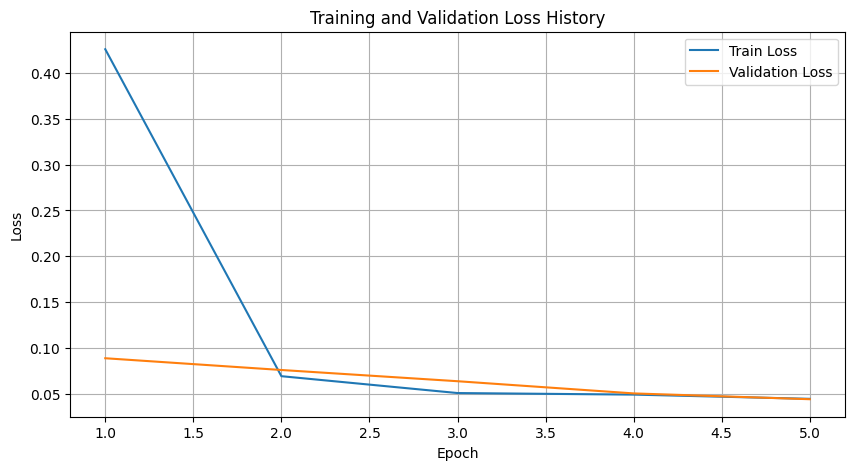

In [2]:
import matplotlib.pyplot as plt

# Load train and validation loss history from files
train_loss_history = []
val_loss_history = []

with open('train_loss_history.txt', 'r') as f:
    train_loss_history = [float(line.strip()) for line in f.readlines()]

with open('val_loss_history.txt', 'r') as f:
    val_loss_history = [float(line.strip()) for line in f.readlines()]

# Plot train and validation loss history
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
test_dataset = VISIONDataset(root_dir=root_dir, split='inference')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
model.eval()
test_loss = 0

In [7]:
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        loss = F.cross_entropy(outputs, masks)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


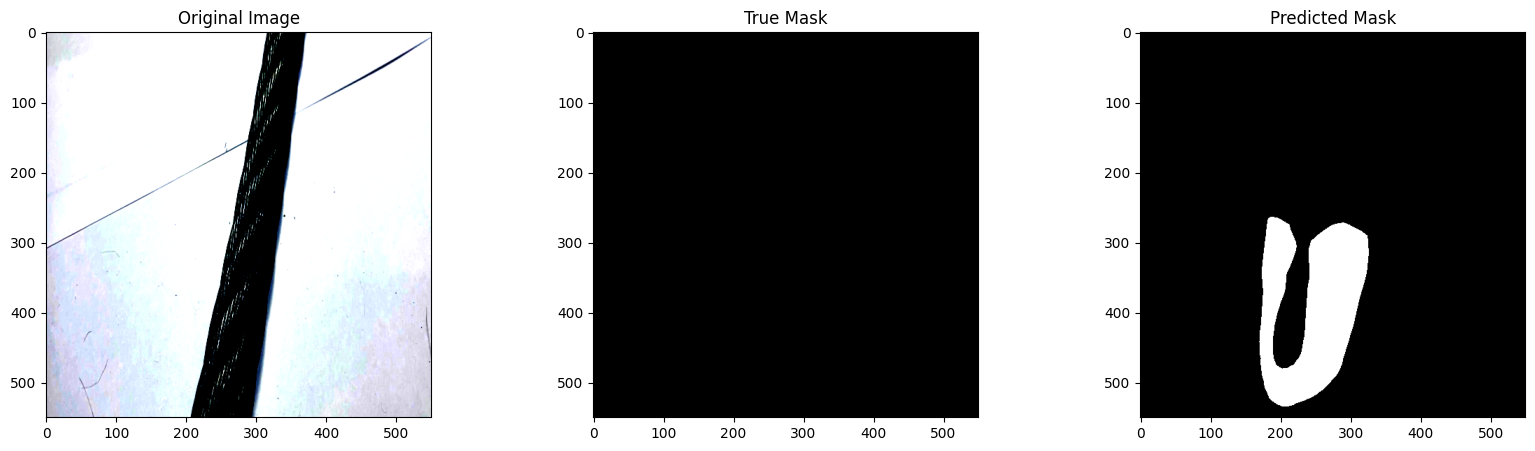

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


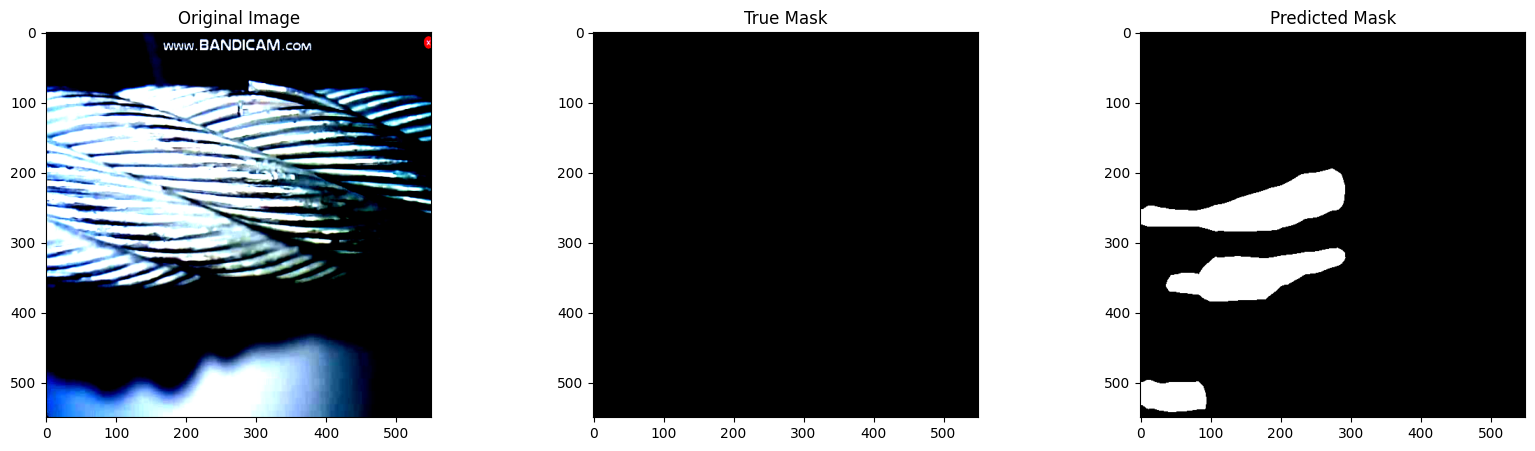

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


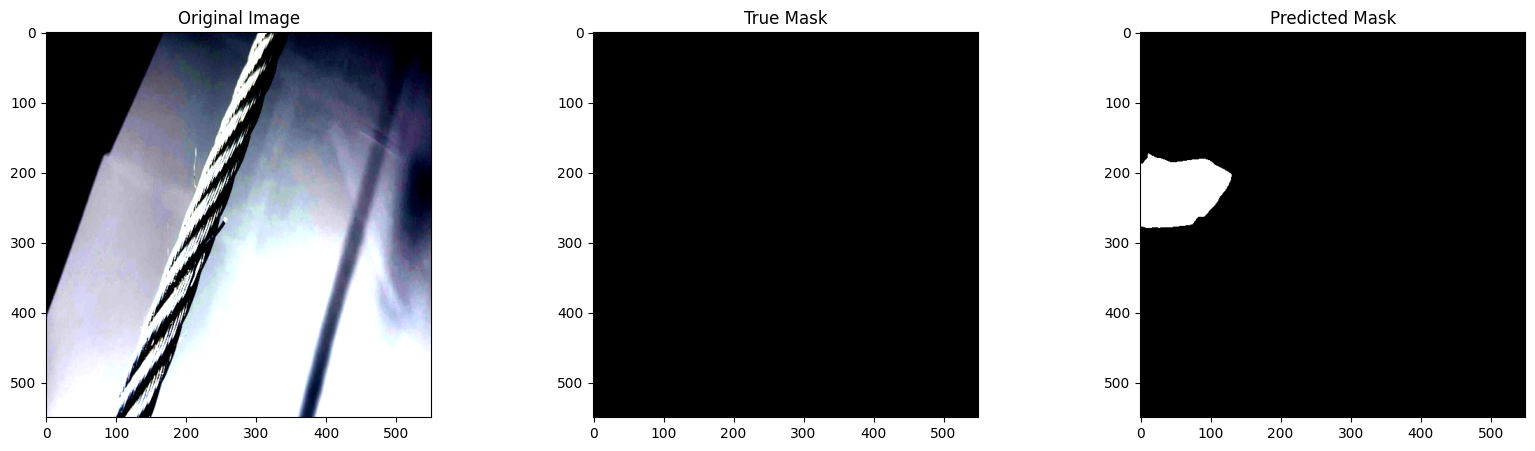

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


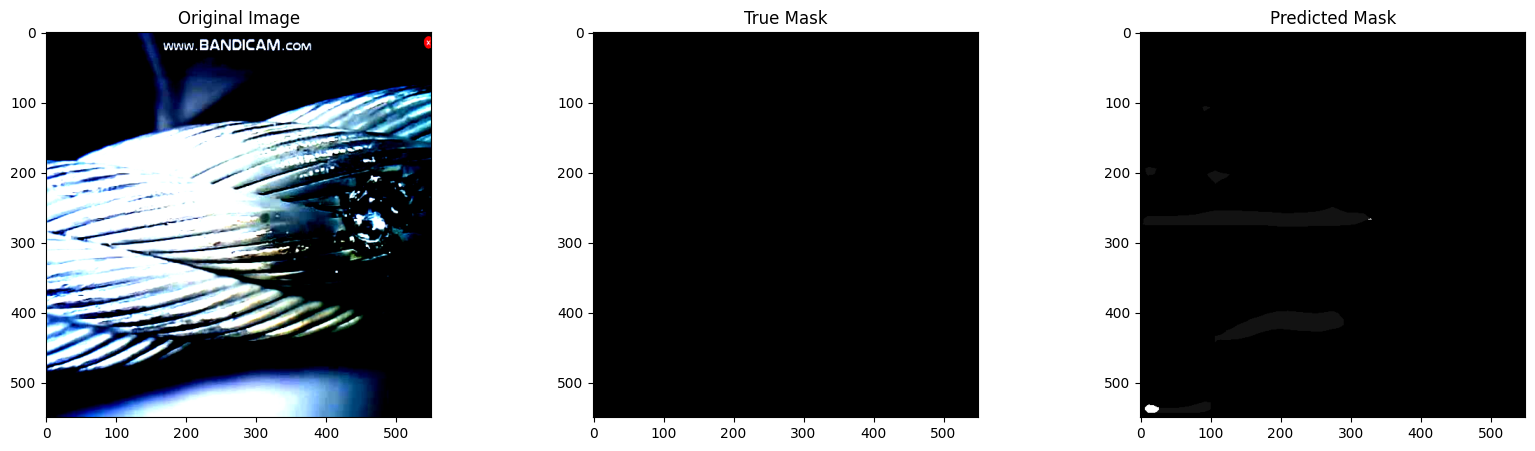

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


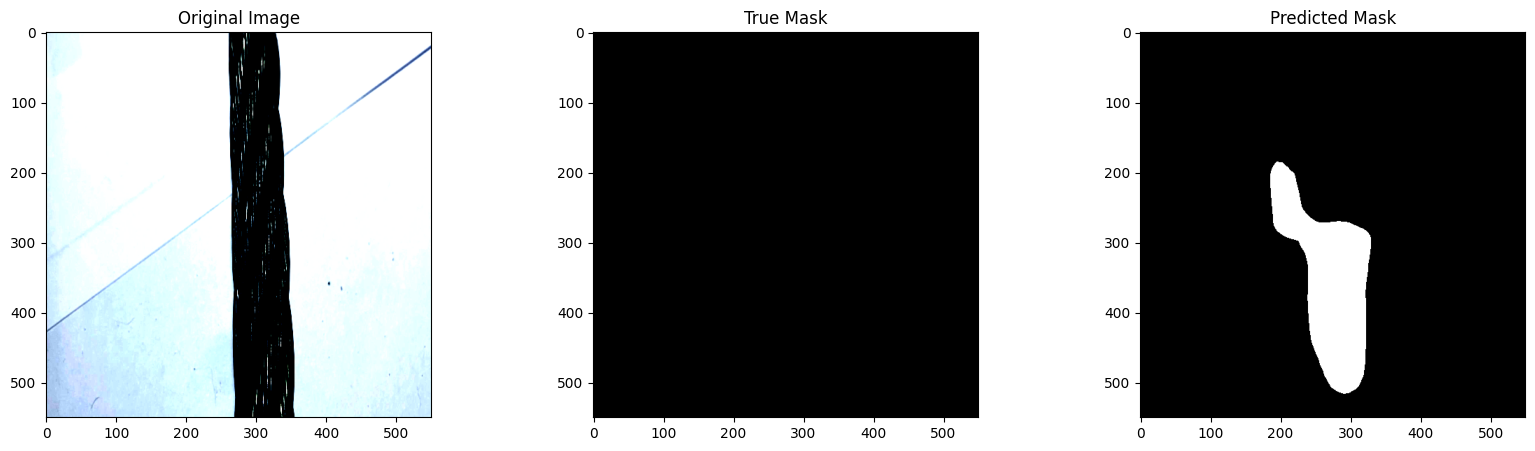

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


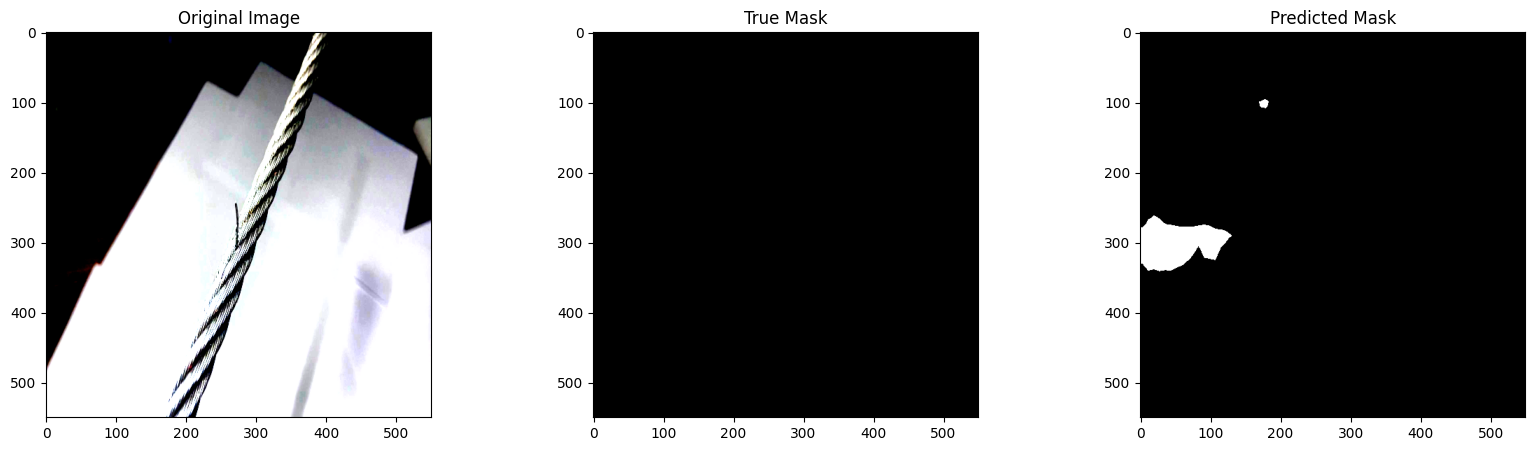

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


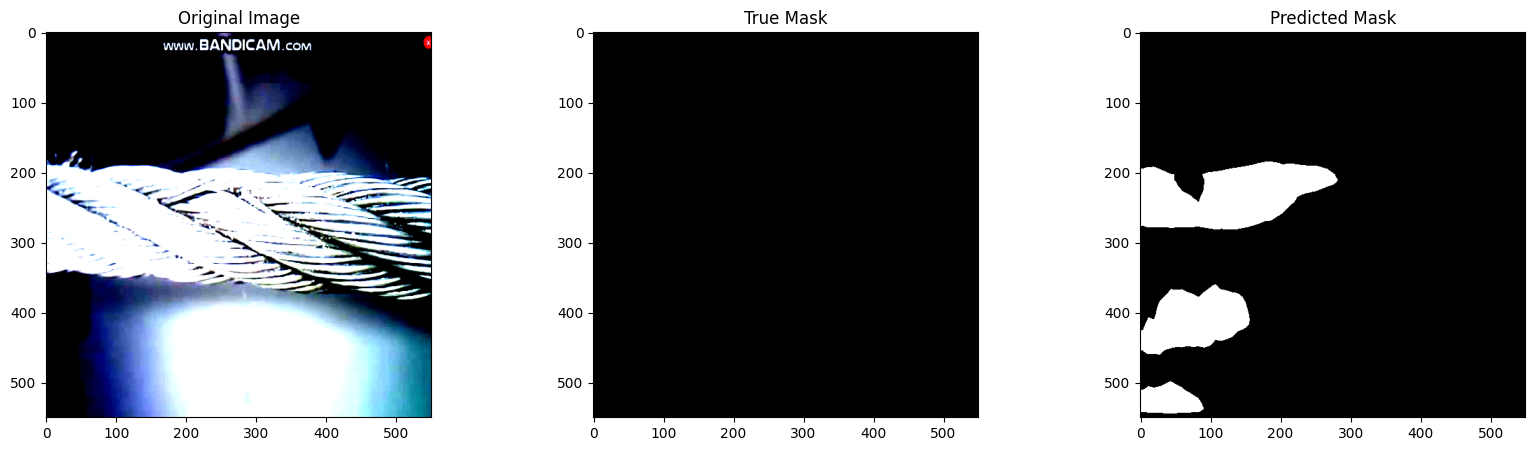

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


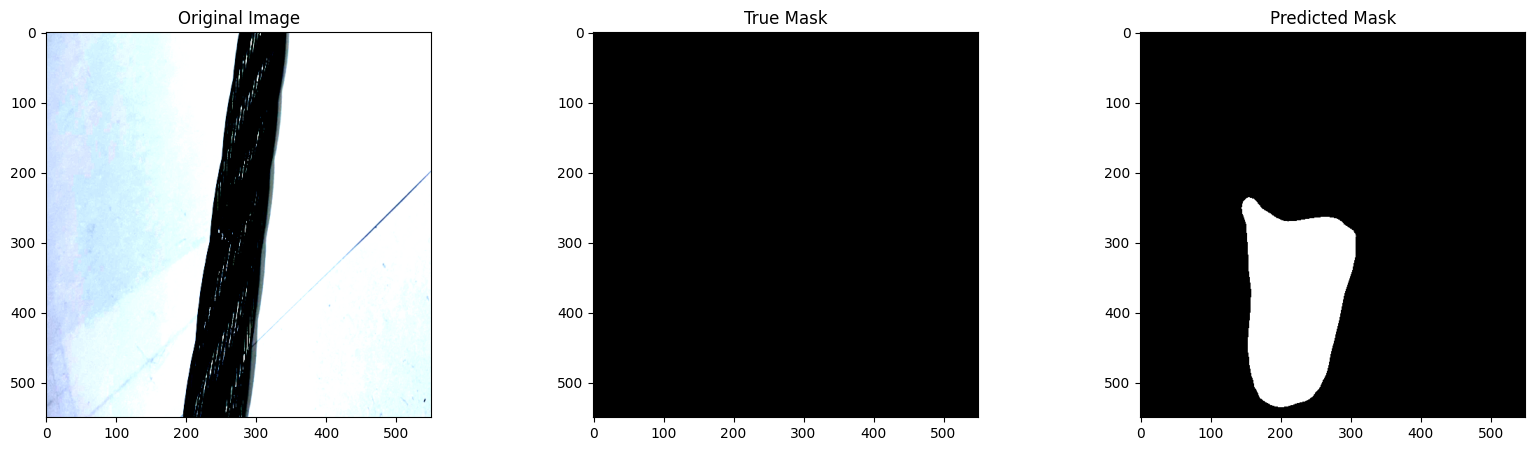

In [9]:
def visualize_prediction(image, mask, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(image.cpu().permute(1, 2, 0))
    axes[0].set_title('Original Image')
    axes[1].imshow(mask.cpu(), cmap='gray')
    axes[1].set_title('True Mask')
    axes[2].imshow(prediction.cpu(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    plt.show()

# Lấy một batch từ tập kiểm tra
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)
with torch.no_grad():
    model.eval()
    outputs = model(images)['out']
    predictions = outputs.argmax(dim=1)

# Visualize kết quả cho một vài mẫu trong batch
for i in range(batch_size):
    visualize_prediction(images[i], masks[i], predictions[i])


In [49]:
import json
import os
import torch.nn.functional as F
import numpy as np
import torch
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.models.segmentation.deeplabv3 import deeplabv3_resnet50, deeplabv3_resnet101
 
# Define the COCO_CLASSES and COCO_LABEL_MAP
COCO_CLASSES = ('__background__','break', 'thunderbolt', "0", "Inclusoes", "Rechupe", "Collision", "Dirty",
               "Gap", "Scratch", "Chip", "PistonMiss", "Porosity", "RCS", "damage", "s_burr", "s_scratch",
               "Defect-A", "Defect-B", "Defect-C", "Defect-D", "Fiber", "Flash Particle", "Hole", "Surface Damage",
               "Tear", "missing_hole", "mouse_bite", "open_circuit", "short", "spur", "spurious_copper",
               "defect1", "defect2", "defect3", "defect4", "defect5", "defect6", "defect7", "t_contamination",
               "t_scratch", "unfinished_surface", "defect", "impurities", "pits")
 
COCO_LABEL_MAP = {cls: idx for (idx, cls) in enumerate(COCO_CLASSES)}
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
 
 
# Define custom dataset
class VISIONDataset(Dataset):
    def __init__(self, root_dir, split="train", annotation_file='_annotations.coco.json'):
        self.root_dir = root_dir
        self.img_dir = os.path.join(self.root_dir, split)
        self.annotation_file = os.path.join(self.root_dir, split, annotation_file)
        self.annotations = self._load_annotations()
 
        # Collect all image file names
        self.img_files = sorted([f for f in os.listdir(self.img_dir)
                                 if f.endswith('.jpg') and not f.startswith('._')])
 
    def _load_annotations(self):
        with open(self.annotation_file, 'r') as f:
            return json.load(f)
 
    def _get_annotation_for_image(self, image_id):
        annotations = [ann for ann in self.annotations['annotations'] if ann['image_id'] == image_id]
        return annotations
    
    def _get_image_id_by_name(self, file_name):
        for image in self.annotations['images']:
            if image['file_name'] == file_name:
                return image['id']
        return None  # Return None if no match is found
 
    def __len__(self):
        return len(self.img_files)
 
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
       
        # Load image
        orig_image = Image.open(img_path).convert('RGB')
 
        # Find corresponding image ID by file name
        image_id = self._get_image_id_by_name(img_name)
 
        # Find corresponding annotations
        image_annotations = self._get_annotation_for_image(image_id)
        print(image_annotations)
        # Create mask
        mask = Image.new('L', orig_image.size, 0)  # Initialize with 0s for background
        draw = ImageDraw.Draw(mask)
        for annotation in image_annotations:
            class_id = annotation['category_id']
            if class_id in COCO_LABEL_MAP.values():
                segmentation = annotation['segmentation']
                print(class_id)
                if isinstance(segmentation[0], list):
                    points = [tuple(point) for segment in segmentation for point in zip(segment[::2], segment[1::2])]
                    draw.polygon(points, fill=class_id + 1)
        mask = np.array(mask)
 
        # Define the transformations including resizing to 550x550
        transform = transforms.Compose([
            transforms.Resize((550, 550)),  # Resize both image and mask to 550x550
            transforms.ToTensor()
        ])
       
        img = transform(orig_image)
 
        mask = Image.fromarray(mask).resize((550, 550), resample=Image.NEAREST)
        mask = torch.tensor(np.array(mask), dtype=torch.int64)
        self.visualize_mask(mask)
        return img, mask
 
    @staticmethod
    def visualize_mask(mask):
        fig, ax = plt.subplots(1)
        ax.imshow(mask, cmap='gray')
        ax.set_title('Segmentation Mask')
        plt.show()
 
    @staticmethod
    def visualize_mask(mask):
        fig, ax = plt.subplots(1)
        ax.imshow(mask, cmap='gray')
        ax.set_title('Segmentation Mask')
        plt.show()

In [50]:
def visualize_sample(img, mask):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img.permute(1, 2, 0))  # Chuyển channel về cuối để phù hợp với yêu cầu của matplotlib
    ax[0].set_title('Original Image')
    ax[0].axis('off')  # Tắt các trục

    ax[1].imshow(mask, cmap='gray')  # Hiển thị mask
    ax[1].set_title('Mask')
    ax[1].axis('off')  # Tắt các trục

    plt.show()

# Giả sử bạn đã khởi tạo tập dữ liệu và DataLoader của bạn
root_dir = '/kaggle/input/vision-all/all'  # Thay đổi theo đường dẫn thực tế của bạn
dataset = VISIONDataset(root_dir=root_dir, split='train')


[{'iscrowd': 0, 'image_id': 103, 'bbox': [1831, 545, 45, 77], 'segmentation': [[1840, 597, 1839, 598, 1838, 598, 1835, 601, 1835, 602, 1834, 603, 1833, 603, 1831, 605, 1831, 606, 1833, 608, 1833, 609, 1839, 615, 1840, 615, 1844, 619, 1845, 619, 1847, 621, 1848, 621, 1849, 622, 1850, 622, 1851, 621, 1852, 621, 1854, 619, 1854, 618, 1856, 616, 1856, 615, 1857, 614, 1857, 612, 1858, 611, 1858, 606, 1857, 605, 1857, 604, 1855, 602, 1853, 602, 1852, 601, 1850, 601, 1849, 600, 1848, 600, 1847, 599, 1845, 599, 1844, 598, 1842, 598, 1841, 597], [1844, 545, 1843, 546, 1841, 546, 1838, 549, 1838, 551, 1834, 555, 1834, 556, 1835, 557, 1835, 558, 1836, 559, 1836, 566, 1837, 567, 1837, 568, 1842, 573, 1843, 573, 1844, 574, 1846, 574, 1849, 577, 1856, 577, 1857, 578, 1855, 580, 1854, 580, 1853, 581, 1852, 581, 1850, 583, 1850, 585, 1849, 586, 1849, 588, 1850, 589, 1850, 590, 1851, 591, 1851, 592, 1854, 595, 1856, 595, 1857, 594, 1858, 594, 1860, 592, 1862, 592, 1863, 591, 1864, 591, 1866, 589, 1866,

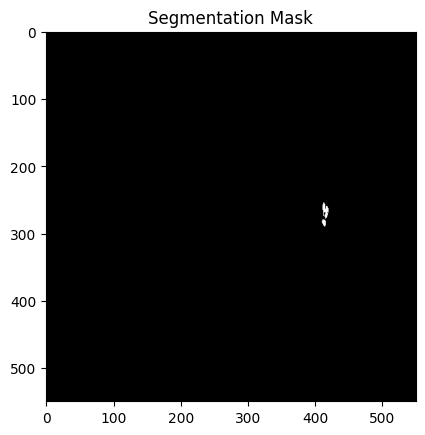

(tensor([[[0.9098, 0.9098, 0.9059,  ..., 0.1373, 0.1137, 0.2000],
          [0.9020, 0.8980, 0.8706,  ..., 0.1255, 0.1255, 0.1804],
          [0.9059, 0.8824, 0.8078,  ..., 0.1412, 0.1490, 0.1922],
          ...,
          [0.5647, 0.4980, 0.3765,  ..., 0.1608, 0.3294, 0.3725],
          [0.5333, 0.5216, 0.4588,  ..., 0.1569, 0.2588, 0.2980],
          [0.6000, 0.5882, 0.5843,  ..., 0.1569, 0.2196, 0.2471]],
 
         [[0.7569, 0.7647, 0.7569,  ..., 0.1020, 0.0980, 0.1765],
          [0.7490, 0.7569, 0.7373,  ..., 0.0902, 0.0902, 0.1451],
          [0.7529, 0.7529, 0.7020,  ..., 0.1059, 0.0980, 0.1333],
          ...,
          [0.4824, 0.3882, 0.2863,  ..., 0.1098, 0.2588, 0.2941],
          [0.4275, 0.3922, 0.3569,  ..., 0.1059, 0.1961, 0.2275],
          [0.4784, 0.4353, 0.4706,  ..., 0.1059, 0.1647, 0.1922]],
 
         [[0.5176, 0.4980, 0.5020,  ..., 0.0902, 0.0627, 0.1216],
          [0.5020, 0.4902, 0.4941,  ..., 0.0627, 0.0471, 0.0863],
          [0.4863, 0.4980, 0.4784,  ...,

In [53]:
dataset.__getitem__(5)

[{'iscrowd': 0, 'image_id': 1, 'bbox': [895, 533, 109, 89], 'segmentation': [[944, 622, 908, 622, 904, 618, 897, 610, 895, 566, 921, 560, 935, 552, 951, 534, 975, 533, 980, 536, 988, 536, 985, 542, 974, 542, 969, 544, 960, 542, 970, 548, 989, 548, 989, 556, 998, 560, 1004, 574, 1000, 591, 992, 598, 969, 600, 952, 618]], 'category_id': 1, 'id': 1, 'area': 6542}, {'iscrowd': 0, 'image_id': 1, 'bbox': [1237, 341, 76, 60], 'segmentation': [[1298, 391, 1289, 391, 1274, 384, 1265, 373, 1262, 361, 1273, 342, 1287, 341, 1298, 350, 1307, 349, 1304, 356, 1313, 364, 1303, 387], [1257, 382, 1244, 378, 1238, 383, 1237, 391, 1243, 392, 1248, 392, 1249, 397, 1254, 401, 1258, 398, 1260, 391, 1258, 386]], 'category_id': 1, 'id': 2, 'area': 2077}]
1
1


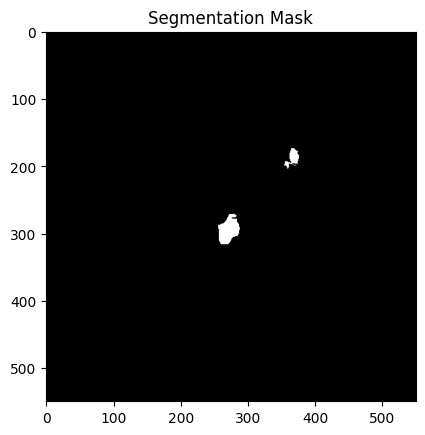

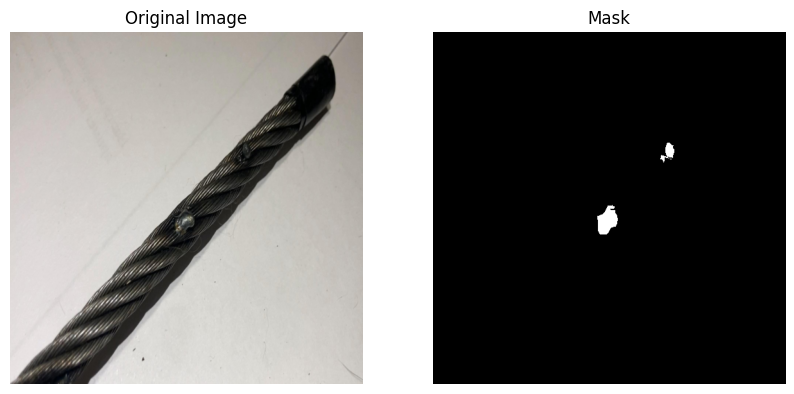

[{'iscrowd': 0, 'image_id': 2, 'bbox': [179, 182, 51, 38], 'segmentation': [[204, 220, 195, 218, 192, 210, 186, 210, 180, 205, 179, 189, 183, 182, 197, 182, 200, 186, 210, 184, 230, 193, 222, 200, 214, 200, 210, 207, 216, 217]], 'category_id': 0, 'id': 3, 'area': 1189}, {'iscrowd': 0, 'image_id': 2, 'bbox': [288, 216, 108, 38], 'segmentation': [[309, 254, 292, 250, 288, 244, 311, 218, 328, 216, 342, 222, 348, 229, 338, 238, 331, 240, 325, 235], [389, 246, 378, 246, 361, 240, 360, 228, 373, 222, 396, 229, 394, 239]], 'category_id': 0, 'id': 4, 'area': 1836}]
0
0


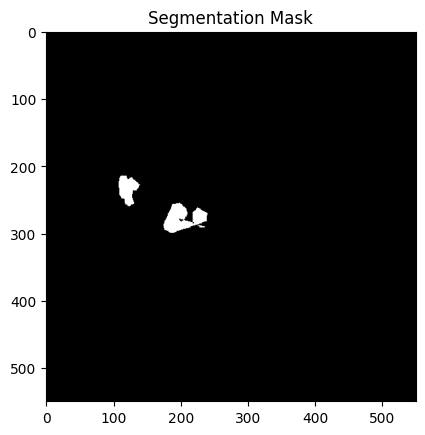

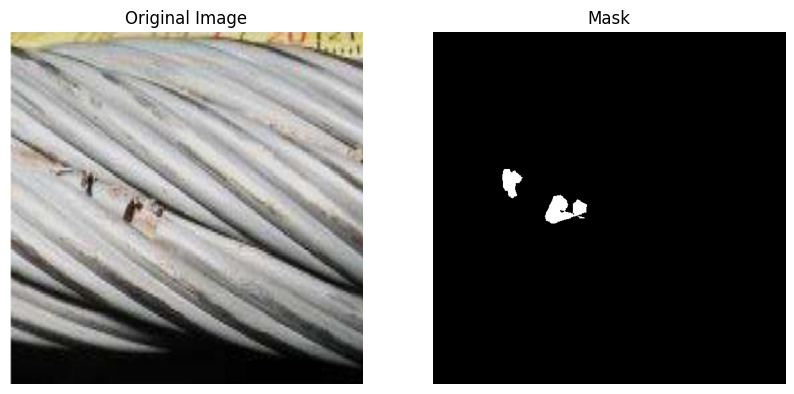

[{'iscrowd': 0, 'image_id': 11, 'bbox': [1167, 296, 117, 80], 'segmentation': [[1217, 376, 1208, 375, 1212, 364, 1187, 376, 1182, 374, 1182, 370, 1175, 372, 1167, 364, 1167, 350, 1185, 340, 1222, 312, 1246, 306, 1262, 296, 1276, 300, 1284, 320, 1276, 337, 1269, 342, 1252, 342, 1248, 344, 1252, 352, 1251, 358]], 'category_id': 1, 'id': 21, 'area': 5043}, {'iscrowd': 0, 'image_id': 11, 'bbox': [499, 806, 151, 120], 'segmentation': [[552, 926, 539, 922, 532, 914, 533, 896, 523, 888, 506, 880, 499, 874, 500, 861, 506, 850, 502, 846, 504, 839, 510, 834, 537, 830, 580, 816, 611, 814, 617, 806, 633, 806, 640, 812, 641, 818, 650, 822, 622, 849, 602, 882, 600, 893, 590, 906, 580, 912, 565, 915]], 'category_id': 1, 'id': 22, 'area': 9808}]
1
1


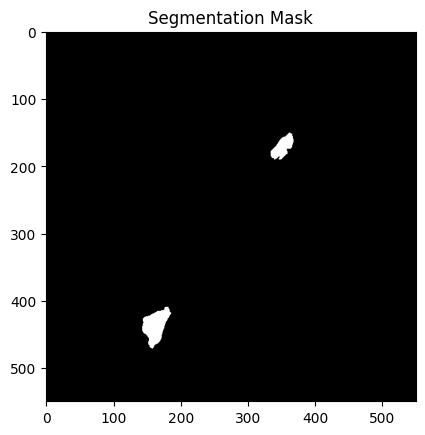

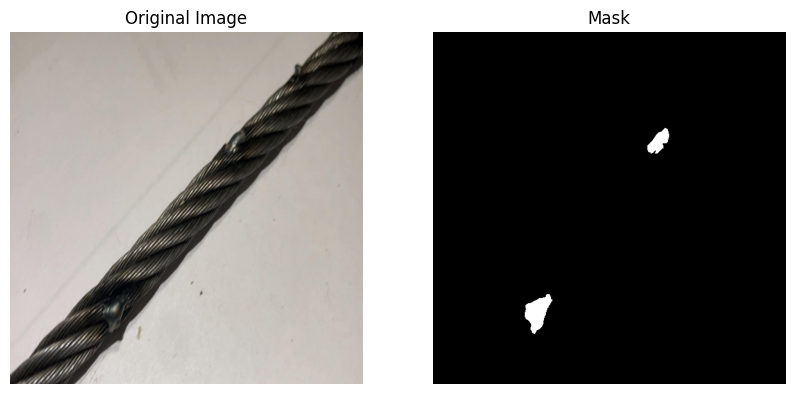

[{'iscrowd': 0, 'image_id': 101, 'bbox': [1944, 576, 53, 92], 'segmentation': [[1951, 647, 1950, 648, 1949, 648, 1946, 651, 1946, 652, 1945, 653, 1945, 655, 1944, 656, 1944, 660, 1948, 664, 1948, 665, 1951, 668, 1953, 668, 1954, 667, 1955, 667, 1956, 666, 1966, 666, 1967, 665, 1968, 665, 1970, 663, 1970, 662, 1972, 660, 1972, 655, 1971, 654, 1971, 653, 1970, 652, 1970, 651, 1969, 650, 1968, 650, 1967, 649, 1963, 649, 1962, 648, 1961, 648, 1960, 647], [1980, 606, 1981, 605, 1982, 606, 1981, 607], [1973, 596, 1975, 596, 1977, 598, 1981, 598, 1983, 600, 1983, 602, 1981, 604, 1981, 605, 1980, 606, 1978, 606, 1977, 607, 1977, 608, 1976, 609, 1976, 610, 1977, 611, 1977, 612, 1976, 613, 1974, 613, 1973, 612, 1973, 611, 1972, 610, 1972, 609, 1971, 608, 1973, 606, 1973, 605, 1972, 604, 1972, 602, 1970, 600, 1970, 599], [1957, 576, 1956, 577, 1957, 578, 1957, 579, 1963, 585, 1963, 586, 1962, 587, 1961, 586, 1958, 586, 1957, 585, 1956, 585, 1954, 583, 1951, 583, 1950, 584, 1950, 586, 1949, 587, 1

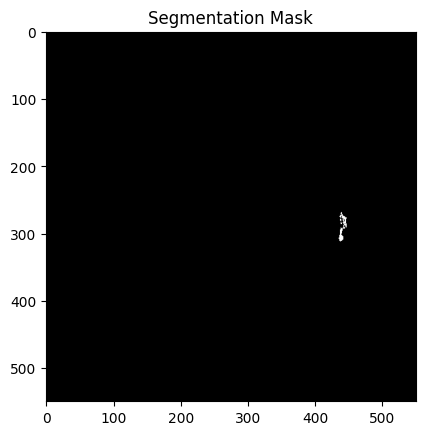

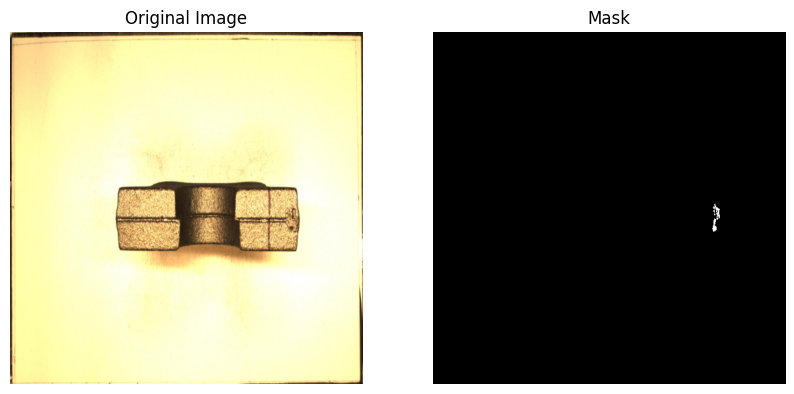

[{'iscrowd': 0, 'image_id': 102, 'bbox': [922, 552, 31, 20], 'segmentation': [[927, 552, 926, 553, 925, 553, 922, 556, 922, 562, 923, 563, 923, 565, 925, 567, 926, 567, 927, 568, 930, 568, 932, 570, 932, 571, 933, 572, 938, 572, 939, 571, 941, 571, 942, 570, 944, 572, 950, 572, 951, 571, 951, 569, 949, 567, 952, 564, 952, 563, 953, 562, 953, 560, 952, 559, 952, 558, 951, 557, 951, 556, 948, 553, 944, 553, 943, 552]], 'category_id': 3, 'id': 129, 'area': 509}, {'iscrowd': 0, 'image_id': 102, 'bbox': [1323, 471, 46, 35], 'segmentation': [[1353, 471, 1352, 472, 1350, 472, 1349, 473, 1347, 473, 1346, 474, 1344, 474, 1343, 475, 1342, 475, 1341, 476, 1340, 476, 1339, 477, 1339, 478, 1337, 480, 1330, 480, 1329, 481, 1327, 481, 1326, 482, 1325, 482, 1324, 483, 1324, 484, 1323, 485, 1323, 487, 1327, 491, 1328, 491, 1329, 492, 1332, 492, 1333, 493, 1333, 498, 1334, 499, 1334, 500, 1335, 501, 1335, 502, 1337, 504, 1338, 504, 1339, 505, 1340, 505, 1341, 506, 1342, 506, 1344, 504, 1344, 500, 1346, 

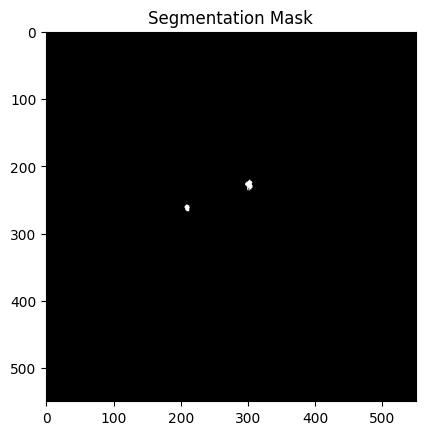

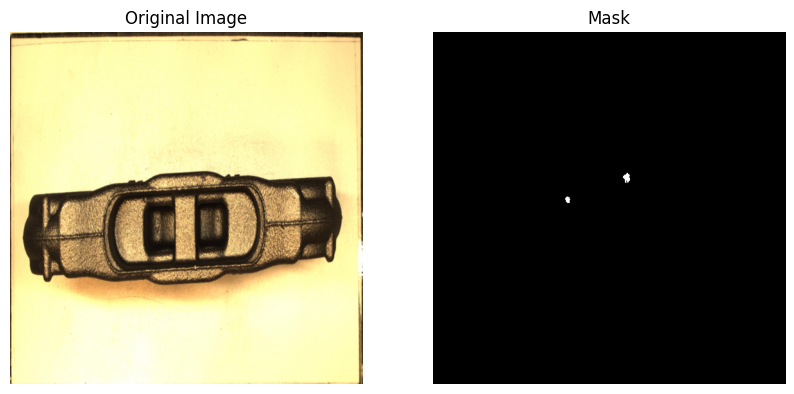

[{'iscrowd': 0, 'image_id': 103, 'bbox': [1831, 545, 45, 77], 'segmentation': [[1840, 597, 1839, 598, 1838, 598, 1835, 601, 1835, 602, 1834, 603, 1833, 603, 1831, 605, 1831, 606, 1833, 608, 1833, 609, 1839, 615, 1840, 615, 1844, 619, 1845, 619, 1847, 621, 1848, 621, 1849, 622, 1850, 622, 1851, 621, 1852, 621, 1854, 619, 1854, 618, 1856, 616, 1856, 615, 1857, 614, 1857, 612, 1858, 611, 1858, 606, 1857, 605, 1857, 604, 1855, 602, 1853, 602, 1852, 601, 1850, 601, 1849, 600, 1848, 600, 1847, 599, 1845, 599, 1844, 598, 1842, 598, 1841, 597], [1844, 545, 1843, 546, 1841, 546, 1838, 549, 1838, 551, 1834, 555, 1834, 556, 1835, 557, 1835, 558, 1836, 559, 1836, 566, 1837, 567, 1837, 568, 1842, 573, 1843, 573, 1844, 574, 1846, 574, 1849, 577, 1856, 577, 1857, 578, 1855, 580, 1854, 580, 1853, 581, 1852, 581, 1850, 583, 1850, 585, 1849, 586, 1849, 588, 1850, 589, 1850, 590, 1851, 591, 1851, 592, 1854, 595, 1856, 595, 1857, 594, 1858, 594, 1860, 592, 1862, 592, 1863, 591, 1864, 591, 1866, 589, 1866,

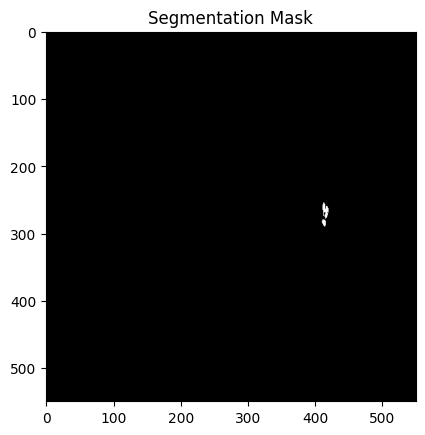

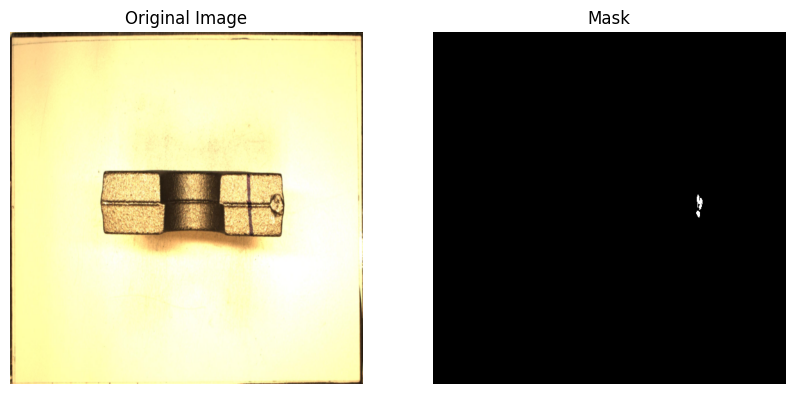

[{'iscrowd': 0, 'image_id': 104, 'bbox': [847, 622, 45, 43], 'segmentation': [[851, 622, 850, 623, 850, 624, 849, 625, 849, 626, 851, 628, 851, 629, 852, 630, 852, 631, 854, 633, 854, 634, 855, 635, 856, 635, 857, 636, 859, 636, 861, 638, 859, 640, 859, 641, 856, 644, 856, 645, 855, 646, 855, 650, 854, 651, 854, 653, 850, 657, 850, 658, 848, 660, 848, 661, 847, 662, 847, 663, 848, 663, 850, 665, 857, 665, 859, 663, 861, 663, 862, 662, 863, 662, 865, 660, 865, 656, 866, 655, 866, 652, 870, 648, 873, 648, 875, 650, 881, 650, 882, 649, 882, 648, 881, 647, 882, 646, 883, 646, 884, 647, 884, 648, 885, 649, 886, 649, 889, 646, 889, 645, 890, 644, 890, 643, 891, 642, 891, 640, 892, 639, 892, 638, 890, 636, 890, 635, 889, 634, 889, 633, 888, 632, 888, 631, 885, 628, 884, 628, 883, 627, 881, 627, 880, 626, 877, 626, 876, 627, 874, 627, 873, 628, 871, 628, 868, 631, 867, 631, 866, 632, 865, 632, 862, 629, 862, 628, 859, 625, 856, 625, 854, 623, 853, 623, 852, 622]], 'category_id': 4, 'id': 132, 

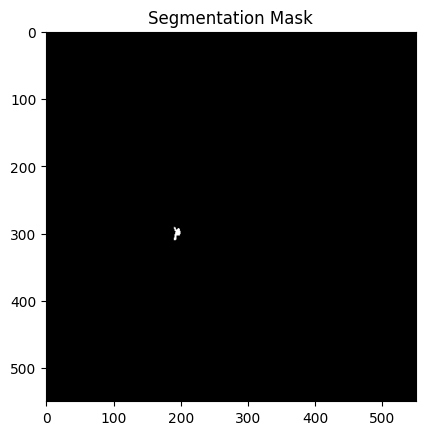

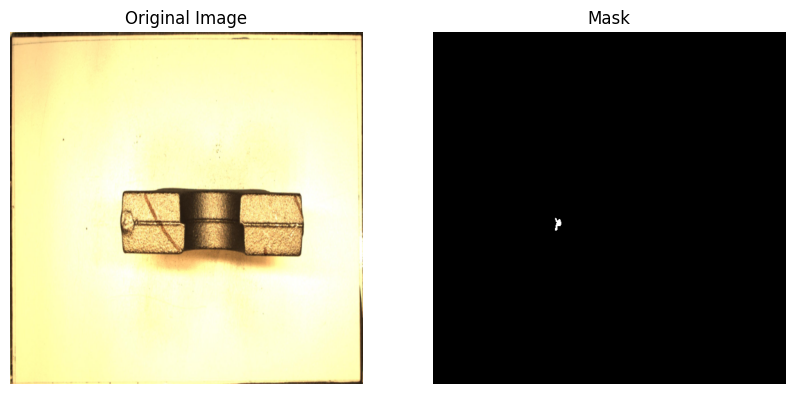

[{'iscrowd': 0, 'image_id': 105, 'bbox': [1278, 711, 28, 24], 'segmentation': [[1287, 711, 1286, 712, 1285, 712, 1284, 713, 1282, 713, 1281, 714, 1280, 714, 1279, 715, 1279, 716, 1278, 717, 1278, 718, 1281, 721, 1282, 721, 1283, 722, 1283, 723, 1285, 725, 1287, 725, 1288, 726, 1289, 726, 1290, 727, 1291, 727, 1292, 728, 1294, 728, 1297, 731, 1298, 731, 1300, 733, 1301, 733, 1302, 734, 1303, 734, 1304, 735, 1305, 735, 1306, 734, 1306, 731, 1305, 730, 1305, 729, 1303, 727, 1303, 726, 1302, 725, 1302, 724, 1301, 723, 1301, 719, 1299, 717, 1298, 717, 1295, 714, 1293, 714, 1292, 713, 1291, 713, 1290, 712, 1289, 712, 1288, 711]], 'category_id': 3, 'id': 133, 'area': 318}]
3


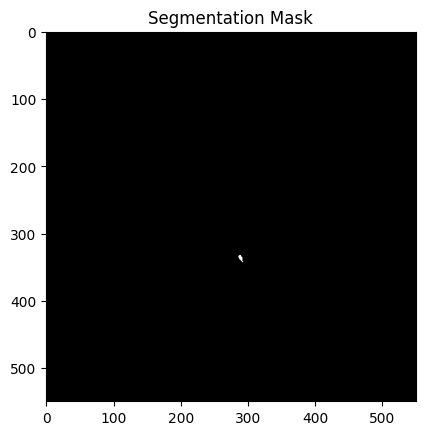

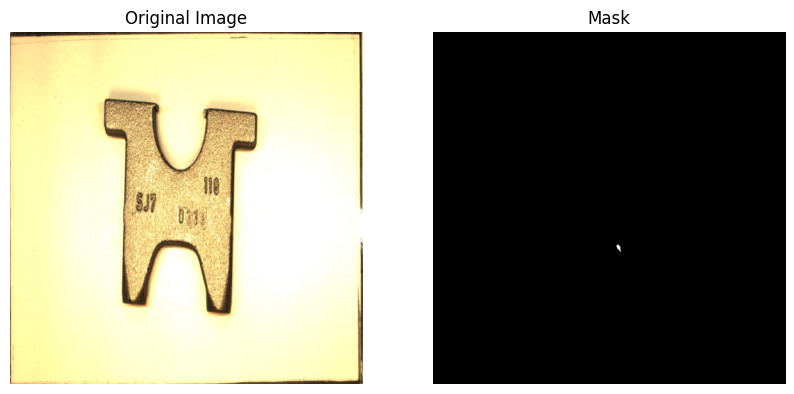

[{'iscrowd': 0, 'image_id': 106, 'bbox': [981, 575, 28, 17], 'segmentation': [[989, 575, 988, 576, 984, 576, 983, 577, 982, 577, 981, 578, 981, 582, 982, 583, 983, 583, 985, 585, 985, 590, 986, 591, 987, 591, 988, 592, 999, 592, 1000, 591, 1002, 591, 1003, 590, 1005, 590, 1006, 589, 1007, 589, 1009, 587, 1009, 583, 1008, 582, 1008, 581, 1006, 579, 1005, 579, 1004, 578, 998, 578, 997, 577, 996, 577, 995, 576, 994, 576, 993, 575]], 'category_id': 3, 'id': 134, 'area': 356}, {'iscrowd': 0, 'image_id': 106, 'bbox': [1067, 664, 19, 12], 'segmentation': [[1069, 664, 1068, 665, 1068, 666, 1067, 667, 1067, 670, 1072, 675, 1073, 675, 1074, 676, 1082, 676, 1083, 675, 1084, 675, 1086, 673, 1086, 671, 1085, 670, 1078, 670, 1077, 669, 1077, 668, 1076, 667, 1074, 667, 1071, 664]], 'category_id': 3, 'id': 135, 'area': 132}]
3
3


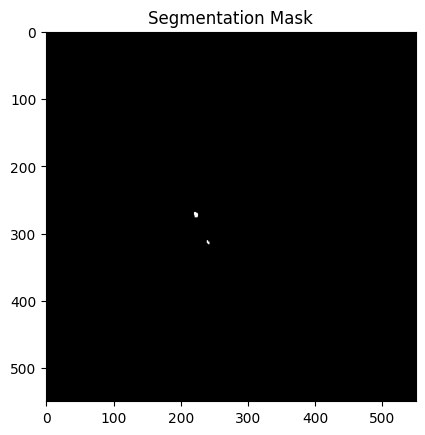

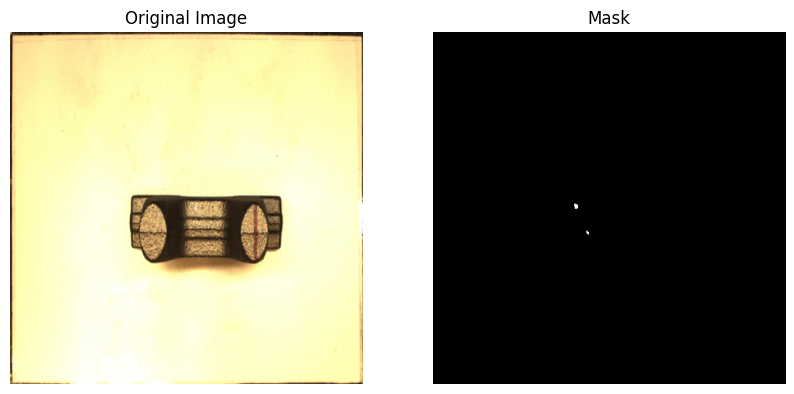

[{'iscrowd': 0, 'image_id': 107, 'bbox': [672, 703, 69, 56], 'segmentation': [[685, 741, 686, 742, 686, 743, 688, 745, 686, 747, 685, 747, 683, 745, 683, 743], [684, 733, 685, 732, 686, 733, 685, 734], [693, 731, 694, 732, 694, 733, 693, 734, 693, 735, 691, 737, 691, 739, 690, 740, 689, 740, 688, 741, 687, 741, 686, 740, 687, 739, 687, 738, 688, 737, 688, 736, 687, 735, 686, 735, 685, 734, 686, 733, 691, 733], [711, 709, 712, 710, 712, 711, 713, 712, 712, 713, 712, 714, 713, 715, 713, 716, 714, 717, 712, 719, 712, 720, 713, 721, 713, 722, 714, 723, 713, 724, 712, 724, 711, 725, 710, 725, 709, 726, 708, 726, 706, 728, 702, 728, 701, 727, 699, 727, 698, 726, 698, 725, 697, 724, 697, 721, 698, 720, 698, 719, 702, 715, 703, 715, 704, 714, 705, 714, 708, 711, 709, 711], [718, 703, 717, 704, 717, 706, 715, 708, 713, 708, 712, 709, 711, 708, 711, 707, 710, 706, 709, 706, 708, 707, 705, 707, 703, 705, 702, 705, 701, 706, 700, 706, 699, 707, 699, 709, 696, 712, 695, 712, 693, 714, 692, 714, 689

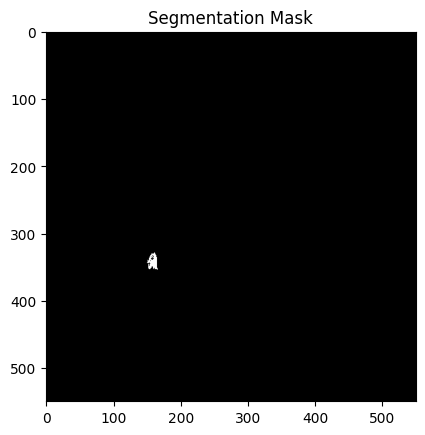

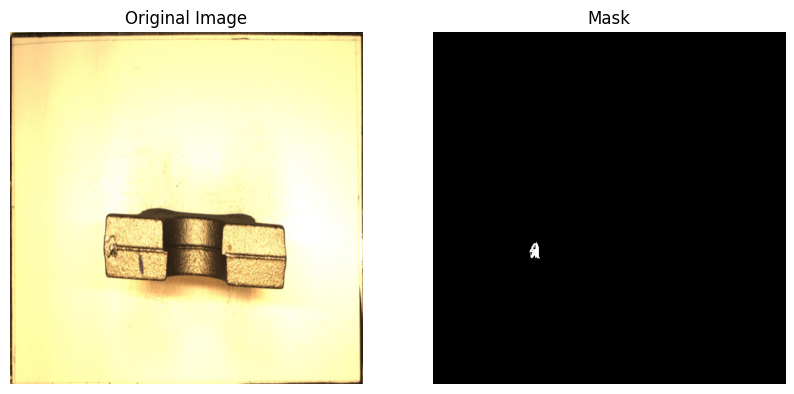

In [54]:
for i in range(10):  # Hiển thị 3 mẫu
    img, mask = dataset[i]  # Lấy mẫu thứ i từ tập dữ liệu
    visualize_sample(img, mask)  # Hiển thị mẫu